In [56]:
import json
import cv2
import scipy.misc
import torch
import torchvision
import utils
import os
import shutil
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torch.nn.parallel
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
from torch.utils.data import sampler
from torchvision import datasets,transforms
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from IPython.display import display

%matplotlib inline

In [83]:
# GLOBAL CONSTANTS
DATA_FILE_TRAIN = 'leafsnap-dataset-train-images.csv'
DATA_FILE_TEST = 'leafsnap-dataset-test-images.csv'
NB_EPOCH = 50
INPUT_SIZE = 224
species = ['abies_concolor', 'abies_nordmanniana', 'acer_campestre', 'acer_ginnala', 'acer_griseum', 'acer_negundo', 'acer_palmatum', 'acer_pensylvanicum', 'acer_platanoides', 'acer_pseudoplatanus', 'acer_rubrum', 'acer_saccharinum', 'acer_saccharum', 'aesculus_flava', 'aesculus_glabra', 'aesculus_hippocastamon', 'aesculus_pavi', 'ailanthus_altissima', 'albizia_julibrissin', 'amelanchier_arborea', 'amelanchier_canadensis', 'amelanchier_laevis', 'asimina_triloba', 'betula_alleghaniensis', 'betula_jacqemontii', 'betula_lenta', 'betula_nigra', 'betula_populifolia', 'broussonettia_papyrifera', 'carpinus_betulus', 'carpinus_caroliniana', 'carya_cordiformis', 'carya_glabra', 'carya_ovata', 'carya_tomentosa', 'castanea_dentata', 'catalpa_bignonioides', 'catalpa_speciosa', 'cedrus_atlantica', 'cedrus_deodara', 'cedrus_libani', 'celtis_occidentalis', 'celtis_tenuifolia', 'cercidiphyllum_japonicum', 'cercis_canadensis', 'chamaecyparis_pisifera', 'chamaecyparis_thyoides', 'chionanthus_retusus', 'chionanthus_virginicus', 'cladrastis_lutea', 'cornus_florida', 'cornus_kousa', 'cornus_mas', 'corylus_colurna', 'crataegus_crus-galli', 'crataegus_laevigata', 'crataegus_phaenopyrum', 'crataegus_pruinosa', 'crataegus_viridis', 'cryptomeria_japonica', 'diospyros_virginiana', 'eucommia_ulmoides', 'evodia_daniellii', 'fagus_grandifolia', 'ficus_carica', 'fraxinus_americana', 'fraxinus_nigra', 'fraxinus_pennsylvanica', 'ginkgo_biloba', 'gleditsia_triacanthos', 'gymnocladus_dioicus', 'halesia_tetraptera', 'ilex_opaca', 'juglans_cinerea', 'juglans_nigra', 'juniperus_virginiana', 'koelreuteria_paniculata', 'larix_decidua', 'liquidambar_styraciflua', 'liriodendron_tulipifera', 'maclura_pomifera', 'magnolia_acuminata', 'magnolia_denudata', 'magnolia_grandiflora', 'magnolia_macrophylla', 'magnolia_soulangiana', 'magnolia_stellata', 'magnolia_tripetala', 'magnolia_virginiana', 'malus_angustifolia', 'malus_baccata', 'malus_coronaria', 'malus_floribunda', 'malus_hupehensis', 'malus_pumila', 'metasequoia_glyptostroboides', 'morus_alba', 'morus_rubra', 'nyssa_sylvatica', 'ostrya_virginiana', 'oxydendrum_arboreum', 'paulownia_tomentosa', 'phellodendron_amurense', 'picea_abies', 'picea_orientalis', 'picea_pungens', 'pinus_bungeana', 'pinus_cembra', 'pinus_densiflora', 'pinus_echinata', 'pinus_flexilis', 'pinus_koraiensis', 'pinus_nigra', 'pinus_parviflora', 'pinus_peucea', 'pinus_pungens', 'pinus_resinosa', 'pinus_rigida', 'pinus_strobus', 'pinus_sylvestris', 'pinus_taeda', 'pinus_thunbergii', 'pinus_virginiana', 'pinus_wallichiana', 'platanus_acerifolia', 'platanus_occidentalis', 'populus_deltoides', 'populus_grandidentata', 'populus_tremuloides', 'prunus_pensylvanica', 'prunus_sargentii', 'prunus_serotina', 'prunus_serrulata', 'prunus_subhirtella', 'prunus_virginiana', 'prunus_yedoensis', 'pseudolarix_amabilis', 'ptelea_trifoliata', 'pyrus_calleryana', 'quercus_acutissima', 'quercus_alba', 'quercus_bicolor', 'quercus_cerris', 'quercus_coccinea', 'quercus_falcata', 'quercus_imbricaria', 'quercus_macrocarpa', 'quercus_marilandica', 'quercus_michauxii', 'quercus_montana', 'quercus_muehlenbergii', 'quercus_nigra', 'quercus_palustris', 'quercus_phellos', 'quercus_robur', 'quercus_rubra', 'quercus_shumardii', 'quercus_stellata', 'quercus_velutina', 'quercus_virginiana', 'robinia_pseudo-acacia', 'salix_babylonica', 'salix_caroliniana', 'salix_matsudana', 'salix_nigra', 'sassafras_albidum', 'staphylea_trifolia', 'stewartia_pseudocamellia', 'styrax_japonica', 'styrax_obassia', 'syringa_reticulata', 'taxodium_distichum', 'tilia_americana', 'tilia_cordata', 'tilia_europaea', 'tilia_tomentosa', 'toona_sinensis', 'tsuga_canadensis', 'ulmus_americana', 'ulmus_glabra', 'ulmus_parvifolia', 'ulmus_procera', 'ulmus_pumila', 'ulmus_rubra', 'zelkova_serrata']
NUM_CLASSES = len(species)
best_prec1 = 0

In [84]:
print('\n[INFO] Loading Training Dataset:')
data_train = pd.read_csv(DATA_FILE_TRAIN, names=['image_paths', 'species'], header=1)
images_train = data_train['image_paths'].tolist()
species_train = data_train['species'].tolist()

display(data_train.head())


[INFO] Loading Training Dataset:


,image_paths,species
1,dataset/train/quercus_virginiana/2.jpg,Quercus virginiana
2,dataset/train/quercus_virginiana/3.jpg,Quercus virginiana
3,dataset/train/quercus_virginiana/4.jpg,Quercus virginiana
4,dataset/train/quercus_stellata/5.jpg,Quercus stellata
5,dataset/train/quercus_stellata/6.jpg,Quercus stellata


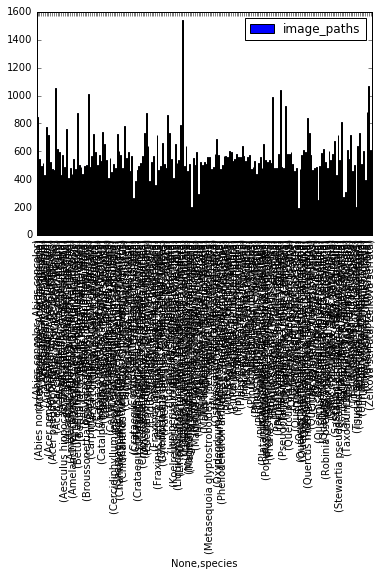

In [85]:
data_train.groupby([species_train, 'species']).count().plot(kind='bar')

In [86]:
print('\n[INFO] Loading Testing Dataset:')
data_test = pd.read_csv(DATA_FILE_TEST, names=['image_paths', 'species'], header=1)
images_test = data_test['image_paths'].tolist()
species_test = data_test['species'].tolist()

display(data_test.head())


[INFO] Loading Testing Dataset:


,image_paths,species
1,dataset/test/abies_concolor/2.jpg,Abies concolor
2,dataset/test/abies_concolor/3.jpg,Abies concolor
3,dataset/test/abies_concolor/4.jpg,Abies concolor
4,dataset/test/abies_concolor/5.jpg,Abies concolor
5,dataset/test/abies_concolor/6.jpg,Abies concolor


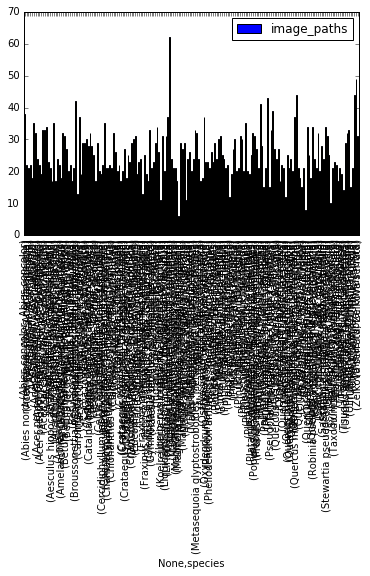

In [87]:
data_test.groupby([species_test, 'species']).count().plot(kind='bar')

In [88]:
traindir = os.path.join('dataset', 'train')
testdir = os.path.join('dataset', 'test')

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_train = datasets.ImageFolder(traindir, transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]))

data_test = datasets.ImageFolder(testdir, transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]))
    
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=True, num_workers=2)

In [89]:
class Model(nn.Module):
    def __init__(self, pretrained_model):
        self.pretrained_model = pretrained_model
        self.last_layer = nn.Linear(1000, 185)

    def forward(self, x):
        return self.last_layer(self.pretrained_model(x))

In [90]:
model = models.vgg16()

mod = list(model.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(4096, 185))
new_classifier = torch.nn.Sequential(*mod)
model.classifier = new_classifier
if torch.cuda.is_available():
    model.cuda()

print(model)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [91]:
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion.cuda()
optimizer = optim.SGD(model.parameters(), 0.003, momentum=0.9, weight_decay=1e-4)

In [92]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [93]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        # target = target.cuda(async=True)
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1, top5=top5))

In [94]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        # target = target.cuda(async=True)
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5))

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

    return top1.avg

In [95]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [96]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = 0.1 * (0.1 ** (epoch // 30))
    if (lr <= 0.0001):
        lr = 0.0001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [97]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
print('\n[INFO] Training Begun')
for epoch in range(1, 2):
    adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    prec1 = validate(val_loader, model, criterion)

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer' : optimizer.state_dict(),
    }, is_best)

In [100]:
print('\n[DONE]')


[DONE]
